# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Evaluation

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
from plots.chapter2 import *

## Helper Functions

In [3]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - computes model's predictions - forward pass
        yhat = model(x)
        # Step 2 - computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - computes gradients for "b" and "w" parameters
        loss.backward()
        # Step 4 - updates parameters using gradients and
        # the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the 
    # train loop
    return perform_train_step

In [4]:
def mini_batch(device, data_loader, step):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

In [5]:
def make_val_step(model, loss_fn):
    # Builds function that performs a step 
    # in the validation loop
    def perform_val_step(x, y):
        # Sets model to EVAL mode
        model.eval()     
        
        # Step 1 - Computes our model's predicted output
        # forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, 
        # since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step

## Data Generation

In [6]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

### Generating training and validation sets

In [7]:
# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

## Full Pipeline

### Data Preparation

In [8]:
%run -i data_preparation/v2.py

### Model Configuration

In [9]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters 
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function 
# and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step = make_val_step(model, loss_fn) 

Overwriting model_configuration/v2.py


In [10]:
%run -i model_configuration/v2.py

### Model Training

In [11]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []                                             

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad():                                    
        val_loss = mini_batch(device, val_loader, val_step)  
        val_losses.append(val_loss)                              

Overwriting model_training/v4.py


In [12]:
%run -i model_training/v4.py

## Model Parameters

In [13]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


## Plotting Losses

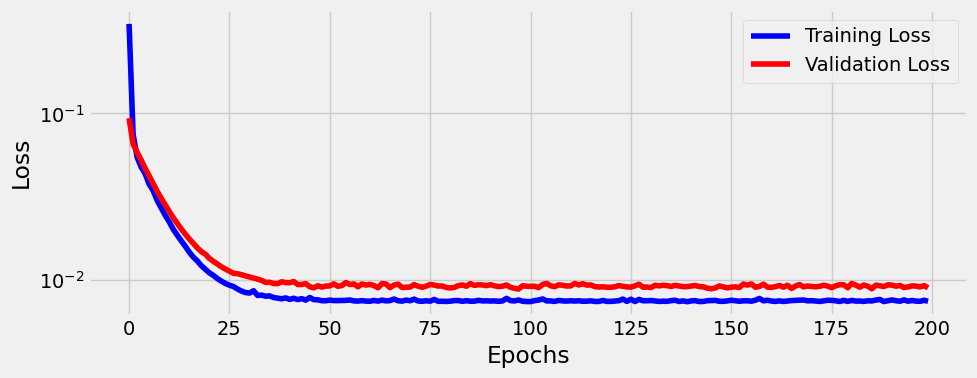

In [14]:
fig = plot_losses(losses, val_losses)